# Load candidates

In [18]:
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:

CACHE = '/home/anhphantq/vdb/cache_train_test'
import os

import pickle
from tqdm import tqdm
train_data = []
num_cands = []

with open(CACHE + '/metadata', 'rb') as f:
  metadata = pickle.load(f)

num_frags = metadata['num_frags']
max_session = metadata['max_session']

for i in tqdm(range(num_frags)):
    with open(CACHE + f'/test_train_data_{i}', 'rb') as f:
      data = pickle.load(f)
      train_data.extend(data[0])
      num_cands.extend(data[1])






100%|██████████| 380/380 [00:07<00:00, 51.40it/s]


In [20]:
import numpy as np
train_data = np.concatenate(train_data)
num_cands = np.concatenate(num_cands)
train_data.shape, num_cands.shape

((5158157, 57), (5158157,))

In [21]:
from xgb_utils import create_test_data

In [22]:
train_data.shape

(5158157, 57)

In [23]:
import pandas as pd 

candidates = create_test_data(train_data, infer = False, max_session=max_session)


In [24]:
del train_data

In [25]:
import pandas as pd
pd.set_option('display.max_columns', candidates.shape[1])

In [26]:
candidates  


,user,item,fitness,inter_clicks,inter_carts,inter_orders,inter_num_sub,inter_time_decay,inter_lts,inter_fts,inter_durability,inter_num_interacts,num_sub,consistency,num_actions,user_degree,user_pr,user_recent_degree,user_recent_pr,num_clicks,num_carts,num_orders,item_degree,item_pr,recent_num_clicks,recent_num_carts,recent_num_orders,item_recent_degree,item_recent_pr,recent_day7_type0,recent_day7_type1,recent_day7_type2,recent_day6_type0,recent_day6_type1,recent_day6_type2,recent_day5_type0,recent_day5_type1,recent_day5_type2,recent_day4_type0,recent_day4_type1,recent_day4_type2,recent_day3_type0,recent_day3_type1,recent_day3_type2,recent_day2_type0,recent_day2_type1,recent_day2_type2,recent_day1_type0,recent_day1_type1,recent_day1_type2,item_glob_last_action,item_glob_first_action,item_glob_time_decay_sum,item_glob_time_decay_sum_click,item_glob_time_decay_sum_cart,item_glob_time_decay_sum_order,item_glob_item_glob_durability
0,12236951.0,1133391.0,5.000000,1.0,0.0,0.0,1.0,1.000000,0.00,0.00,0.0,1.0,0.0,1.000000,1.0,1.0,1.423478e-08,1.0,2.431248e-08,2122.0,10.0,2.0,1410.0,6.736371e-06,827.0,5.0,2.0,526.0,5.776945e-06,56.0,0.0,0.0,83.0,0.0,0.0,85.0,1.0,0.0,121.0,2.0,0.0,93.0,1.0,0.0,114.0,1.0,0.0,104.0,0.0,0.0,20.989294,0.003368,853.075718,847.406783,5.076463,0.592472,20.985926
1,12406840.0,1374573.0,5.000000,1.0,0.0,0.0,1.0,1.000000,1.00,1.00,0.0,1.0,0.0,0.190017,2.0,2.0,1.721432e-08,2.0,3.049933e-08,508.0,39.0,12.0,385.0,1.514062e-06,194.0,9.0,2.0,156.0,1.345406e-06,25.0,1.0,0.0,33.0,1.0,0.0,29.0,1.0,0.0,23.0,1.0,0.0,13.0,2.0,0.0,31.0,1.0,1.0,27.0,0.0,0.0,20.950590,0.193229,239.122461,221.443989,13.760121,3.918351,20.757361
2,12406840.0,1364983.0,2.500000,1.0,0.0,0.0,1.0,0.500000,0.00,0.00,0.0,1.0,0.0,0.190017,2.0,2.0,1.721432e-08,2.0,3.049933e-08,752.0,33.0,12.0,538.0,2.340448e-06,318.0,14.0,5.0,212.0,2.043050e-06,72.0,2.0,1.0,42.0,2.0,0.0,52.0,1.0,0.0,35.0,0.0,0.0,41.0,2.0,1.0,33.0,0.0,0.0,35.0,2.0,0.0,20.977373,0.030810,362.244681,345.062547,13.173536,4.008598,20.946562
3,11932698.0,1775620.0,5.000000,1.0,0.0,0.0,1.0,1.000000,0.00,0.00,0.0,1.0,0.0,1.000000,1.0,1.0,1.440217e-08,1.0,2.445619e-08,396.0,51.0,8.0,302.0,1.502298e-06,183.0,18.0,3.0,136.0,1.516653e-06,31.0,6.0,0.0,18.0,2.0,2.0,21.0,1.0,0.0,14.0,2.0,0.0,33.0,2.0,0.0,18.0,3.0,1.0,28.0,4.0,0.0,20.996829,0.029306,211.363559,183.716471,24.344982,3.302106,20.967523
4,11440634.0,485256.0,20.000000,2.0,2.0,0.0,1.0,1.000000,0.00,0.00,224.0,4.0,0.0,0.155858,4.0,1.0,2.727245e-08,1.0,4.202552e-08,28739.0,7845.0,0.0,12763.0,2.567406e-04,28739.0,7845.0,0.0,12763.0,4.061398e-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5158152,12442084.0,1682774.0,5.000000,1.0,0.0,0.0,1.0,1.000000,1.00,1.00,0.0,1.0,0.0,0.166188,4.0,4.0,2.528759e-08,4.0,4.806115e-08,313.0,33.0,5.0,190.0,8.624553e-07,161.0,17.0,4.0,94.0,8.761307e-07,30.0,1.0,0.0,13.0,2.0,1.0,23.0,2.0,1.0,24.0,4.0,0.0,13.0,1.0,0.0,20.0,4.0,1.0,29.0,0.0,0.0,20.984444,0.329444,180.867681,162.951647,15.442543,2.473491,20.655000
5158153,12442084.0,1718346.0,4.292827,1.0,0.0,0.0,1.0,0.858565,0.78,0.78,0.0,1.0,0.0,0.166188,4.0,4.0,2.528759e-08,4.0,4.806115e-08,115.0,3.0,0.0,77.0,3.369399e-07,63.0,2.0,0.0,35.0,3.360742e-07,3.0,0.0,0.0,13.0,0.0,0.0,7.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,9.0,1.0,0.0,20.930428,0.051065,51.886590,50.778944,1.107646,0.000000,20.879363
5158154,12442084.0,1361306.0,3.584888,1.0,0.0,0.0,1.0,0.716978,0.52,0.52,0.0,1.0,0.0,0.166188,4.0,4.0,2.528759e-08,4.0,4.806115e-08,717.0,27.0,8.0,495.0,2.270422e-06,281.0,15.0,2.0,171.0,1.779857e-06,24.0,0.0,0.0,40.0,5.0,0.0,40.0,1.0,0.0,22.0,1.0,0.0,38.0,0.0,0.0,38.0,3.0,1.0,28.0,2.0,0.0,20.982002,0.057558,299.270279,284.354857,12.345292

In [27]:
len(candidates.columns)

57

# Train params

In [28]:
PARAMS = {
    'max_depth' : 6,
    'eta': 0.5,    
    'min_child_weight': 1000,
    'tree_method': 'hist',
}
N_SPLITS = 3
NUM_TREE = 1000
MODEL_PATH = '/home/anhphantq/xgboost_test'
VERSION = '8'

# Train for each type

In [29]:
from xgb_utils import get_len_group

In [30]:
import pandas as pd 
import numpy as np
tar = pd.read_parquet('/home/anhphantq/otto/splitted_data/test_labels.parquet')
tar = tar.loc[(tar['session'] <= candidates['user'].max()) & (tar['session'] >= candidates['user'].min()) ]
aids = tar.ground_truth.explode().astype('int32').rename('item')
tar = tar[['session', 'type']].rename({'session':'user'},axis=1)
tar = tar.merge(aids, left_index=True, right_index=True, how='left')
tar['type'] = tar['type'].apply(lambda x: 0 if x == 'clicks' else 1 if x == 'carts' else 2)
tar['label'] = 1

In [31]:
tar

,user,type,item,label
113400,11188590,0,607328,1
113401,11188591,0,557157,1
113402,11188591,1,1597320,1
113402,11188591,1,1236555,1
113402,11188591,1,970284,1
...,...,...,...,...
2212687,12899774,0,1399483,1
2212688,12899775,0,1760714,1
2212689,12899776,0,1737908,1
2212690,12899777,0,384045,1


In [32]:
candidates

,user,item,fitness,inter_clicks,inter_carts,inter_orders,inter_num_sub,inter_time_decay,inter_lts,inter_fts,inter_durability,inter_num_interacts,num_sub,consistency,num_actions,user_degree,user_pr,user_recent_degree,user_recent_pr,num_clicks,num_carts,num_orders,item_degree,item_pr,recent_num_clicks,recent_num_carts,recent_num_orders,item_recent_degree,item_recent_pr,recent_day7_type0,recent_day7_type1,recent_day7_type2,recent_day6_type0,recent_day6_type1,recent_day6_type2,recent_day5_type0,recent_day5_type1,recent_day5_type2,recent_day4_type0,recent_day4_type1,recent_day4_type2,recent_day3_type0,recent_day3_type1,recent_day3_type2,recent_day2_type0,recent_day2_type1,recent_day2_type2,recent_day1_type0,recent_day1_type1,recent_day1_type2,item_glob_last_action,item_glob_first_action,item_glob_time_decay_sum,item_glob_time_decay_sum_click,item_glob_time_decay_sum_cart,item_glob_time_decay_sum_order,item_glob_item_glob_durability
0,12236951.0,1133391.0,5.000000,1.0,0.0,0.0,1.0,1.000000,0.00,0.00,0.0,1.0,0.0,1.000000,1.0,1.0,1.423478e-08,1.0,2.431248e-08,2122.0,10.0,2.0,1410.0,6.736371e-06,827.0,5.0,2.0,526.0,5.776945e-06,56.0,0.0,0.0,83.0,0.0,0.0,85.0,1.0,0.0,121.0,2.0,0.0,93.0,1.0,0.0,114.0,1.0,0.0,104.0,0.0,0.0,20.989294,0.003368,853.075718,847.406783,5.076463,0.592472,20.985926
1,12406840.0,1374573.0,5.000000,1.0,0.0,0.0,1.0,1.000000,1.00,1.00,0.0,1.0,0.0,0.190017,2.0,2.0,1.721432e-08,2.0,3.049933e-08,508.0,39.0,12.0,385.0,1.514062e-06,194.0,9.0,2.0,156.0,1.345406e-06,25.0,1.0,0.0,33.0,1.0,0.0,29.0,1.0,0.0,23.0,1.0,0.0,13.0,2.0,0.0,31.0,1.0,1.0,27.0,0.0,0.0,20.950590,0.193229,239.122461,221.443989,13.760121,3.918351,20.757361
2,12406840.0,1364983.0,2.500000,1.0,0.0,0.0,1.0,0.500000,0.00,0.00,0.0,1.0,0.0,0.190017,2.0,2.0,1.721432e-08,2.0,3.049933e-08,752.0,33.0,12.0,538.0,2.340448e-06,318.0,14.0,5.0,212.0,2.043050e-06,72.0,2.0,1.0,42.0,2.0,0.0,52.0,1.0,0.0,35.0,0.0,0.0,41.0,2.0,1.0,33.0,0.0,0.0,35.0,2.0,0.0,20.977373,0.030810,362.244681,345.062547,13.173536,4.008598,20.946562
3,11932698.0,1775620.0,5.000000,1.0,0.0,0.0,1.0,1.000000,0.00,0.00,0.0,1.0,0.0,1.000000,1.0,1.0,1.440217e-08,1.0,2.445619e-08,396.0,51.0,8.0,302.0,1.502298e-06,183.0,18.0,3.0,136.0,1.516653e-06,31.0,6.0,0.0,18.0,2.0,2.0,21.0,1.0,0.0,14.0,2.0,0.0,33.0,2.0,0.0,18.0,3.0,1.0,28.0,4.0,0.0,20.996829,0.029306,211.363559,183.716471,24.344982,3.302106,20.967523
4,11440634.0,485256.0,20.000000,2.0,2.0,0.0,1.0,1.000000,0.00,0.00,224.0,4.0,0.0,0.155858,4.0,1.0,2.727245e-08,1.0,4.202552e-08,28739.0,7845.0,0.0,12763.0,2.567406e-04,28739.0,7845.0,0.0,12763.0,4.061398e-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5158152,12442084.0,1682774.0,5.000000,1.0,0.0,0.0,1.0,1.000000,1.00,1.00,0.0,1.0,0.0,0.166188,4.0,4.0,2.528759e-08,4.0,4.806115e-08,313.0,33.0,5.0,190.0,8.624553e-07,161.0,17.0,4.0,94.0,8.761307e-07,30.0,1.0,0.0,13.0,2.0,1.0,23.0,2.0,1.0,24.0,4.0,0.0,13.0,1.0,0.0,20.0,4.0,1.0,29.0,0.0,0.0,20.984444,0.329444,180.867681,162.951647,15.442543,2.473491,20.655000
5158153,12442084.0,1718346.0,4.292827,1.0,0.0,0.0,1.0,0.858565,0.78,0.78,0.0,1.0,0.0,0.166188,4.0,4.0,2.528759e-08,4.0,4.806115e-08,115.0,3.0,0.0,77.0,3.369399e-07,63.0,2.0,0.0,35.0,3.360742e-07,3.0,0.0,0.0,13.0,0.0,0.0,7.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,9.0,1.0,0.0,20.930428,0.051065,51.886590,50.778944,1.107646,0.000000,20.879363
5158154,12442084.0,1361306.0,3.584888,1.0,0.0,0.0,1.0,0.716978,0.52,0.52,0.0,1.0,0.0,0.166188,4.0,4.0,2.528759e-08,4.0,4.806115e-08,717.0,27.0,8.0,495.0,2.270422e-06,281.0,15.0,2.0,171.0,1.779857e-06,24.0,0.0,0.0,40.0,5.0,0.0,40.0,1.0,0.0,22.0,1.0,0.0,38.0,0.0,0.0,38.0,3.0,1.0,28.0,2.0,0.0,20.982002,0.057558,299.270279,284.354857,12.345292

In [33]:
import xgboost as xgb
from sklearn.model_selection import GroupKFold
import os
import shutil
import matplotlib.pyplot as plt
def train(tar_, candidates_, t, num_cands, id_type):
  name = f'/{t}_only_'
  try:
    shutil.rmtree(MODEL_PATH + name + VERSION)
  except:
    pass
  else:
    print('remove old version')
  
  tar = tar_[tar_['type'] == id_type].copy()
  candidates = candidates_.copy()
  candidates['type'] = id_type
  
  candidates['user_type'] = candidates['user'] * 10 + candidates['type']
  tar['user_type'] = tar['user'] * 10 + tar['type']
  del tar['type'], tar['user']
  candidates = candidates.merge(tar,on=['user_type','item'],how='left').fillna(0)
  candidates['label'] = candidates['label'].values.astype(np.int16)

  # neg_idx = np.argwhere(candidates['label'].values.flatten() == 0)
  # neg_idx = np.random.permutation(neg_idx)[: int(len(neg_idx) * 0.5)]
  # candidates = candidates.drop(neg_idx.flatten()).reset_index()
  # num_cands = candidates[['user', 'item']].groupby('user').count().reset_index()
  # num_cands['num_cands'] = num_cands['item']
  # del num_cands['item'] 
  # candidates = candidates.merge(num_cands,on=['user'],how='left')
  # num_cands = candidates['num_cands'].values


  print(np.sum(candidates['label']), candidates.shape[0])
  
  del candidates['type'], candidates['user_type']

  skf = GroupKFold(n_splits=N_SPLITS)
  fig, axs = plt.subplots(1,3, figsize = (30, 10))
  for fold,(train_idx, valid_idx) in enumerate(skf.split(candidates, candidates['label'], groups=candidates['user'] )):

      X_train = candidates.iloc[train_idx, 2 : -1]
      y_train = candidates.iloc[train_idx, -1]
      X_valid = candidates.iloc[valid_idx, 2 : -1]
      y_valid = candidates.iloc[valid_idx, -1]

      dtrain = xgb.DMatrix(X_train, y_train, nthread = os.cpu_count() ) 
      dtrain.set_group(get_len_group(train_idx, num_cands))
      dvalid = xgb.DMatrix(X_valid, y_valid, nthread = os.cpu_count() ) 
      dvalid.set_group(get_len_group(valid_idx, num_cands))
      
      xgb_parms = {'objective':'rank:pairwise', 'nthread' : os.cpu_count(),
      **PARAMS}
      model = xgb.train(xgb_parms, 
          dtrain=dtrain,
          evals=[(dtrain,'train'),(dvalid,'valid')],
          num_boost_round=NUM_TREE,
          verbose_eval=5,
          early_stopping_rounds= 15, )
      try:
        os.mkdir(MODEL_PATH + name + VERSION)
      except:
        pass
      model.save_model(MODEL_PATH + name + VERSION + f'/XGB_fold{fold}.xgb')
      xgb.plot_importance(model, ax = axs[fold], max_num_features= 50)

540517 5158157
[0]	train-map:0.95451	valid-map:0.95452
[5]	train-map:0.95599	valid-map:0.95586
[10]	train-map:0.95655	valid-map:0.95643
[15]	train-map:0.95682	valid-map:0.95651
[20]	train-map:0.95695	valid-map:0.95658
[25]	train-map:0.95721	valid-map:0.95670
[30]	train-map:0.95727	valid-map:0.95669
[35]	train-map:0.95749	valid-map:0.95687
[40]	train-map:0.95759	valid-map:0.95694
[45]	train-map:0.95765	valid-map:0.95696
[50]	train-map:0.95773	valid-map:0.95703
[55]	train-map:0.95778	valid-map:0.95706
[60]	train-map:0.95785	valid-map:0.95710
[65]	train-map:0.95793	valid-map:0.95714
[70]	train-map:0.95802	valid-map:0.95715
[75]	train-map:0.95810	valid-map:0.95720
[80]	train-map:0.95816	valid-map:0.95722
[85]	train-map:0.95819	valid-map:0.95717
[90]	train-map:0.95824	valid-map:0.95715
[0]	train-map:0.95476	valid-map:0.95492
[5]	train-map:0.95581	valid-map:0.95590
[10]	train-map:0.95659	valid-map:0.95662
[15]	train-map:0.95695	valid-map:0.95692
[20]	train-map:0.95712	valid-map:0.95699
[25]	

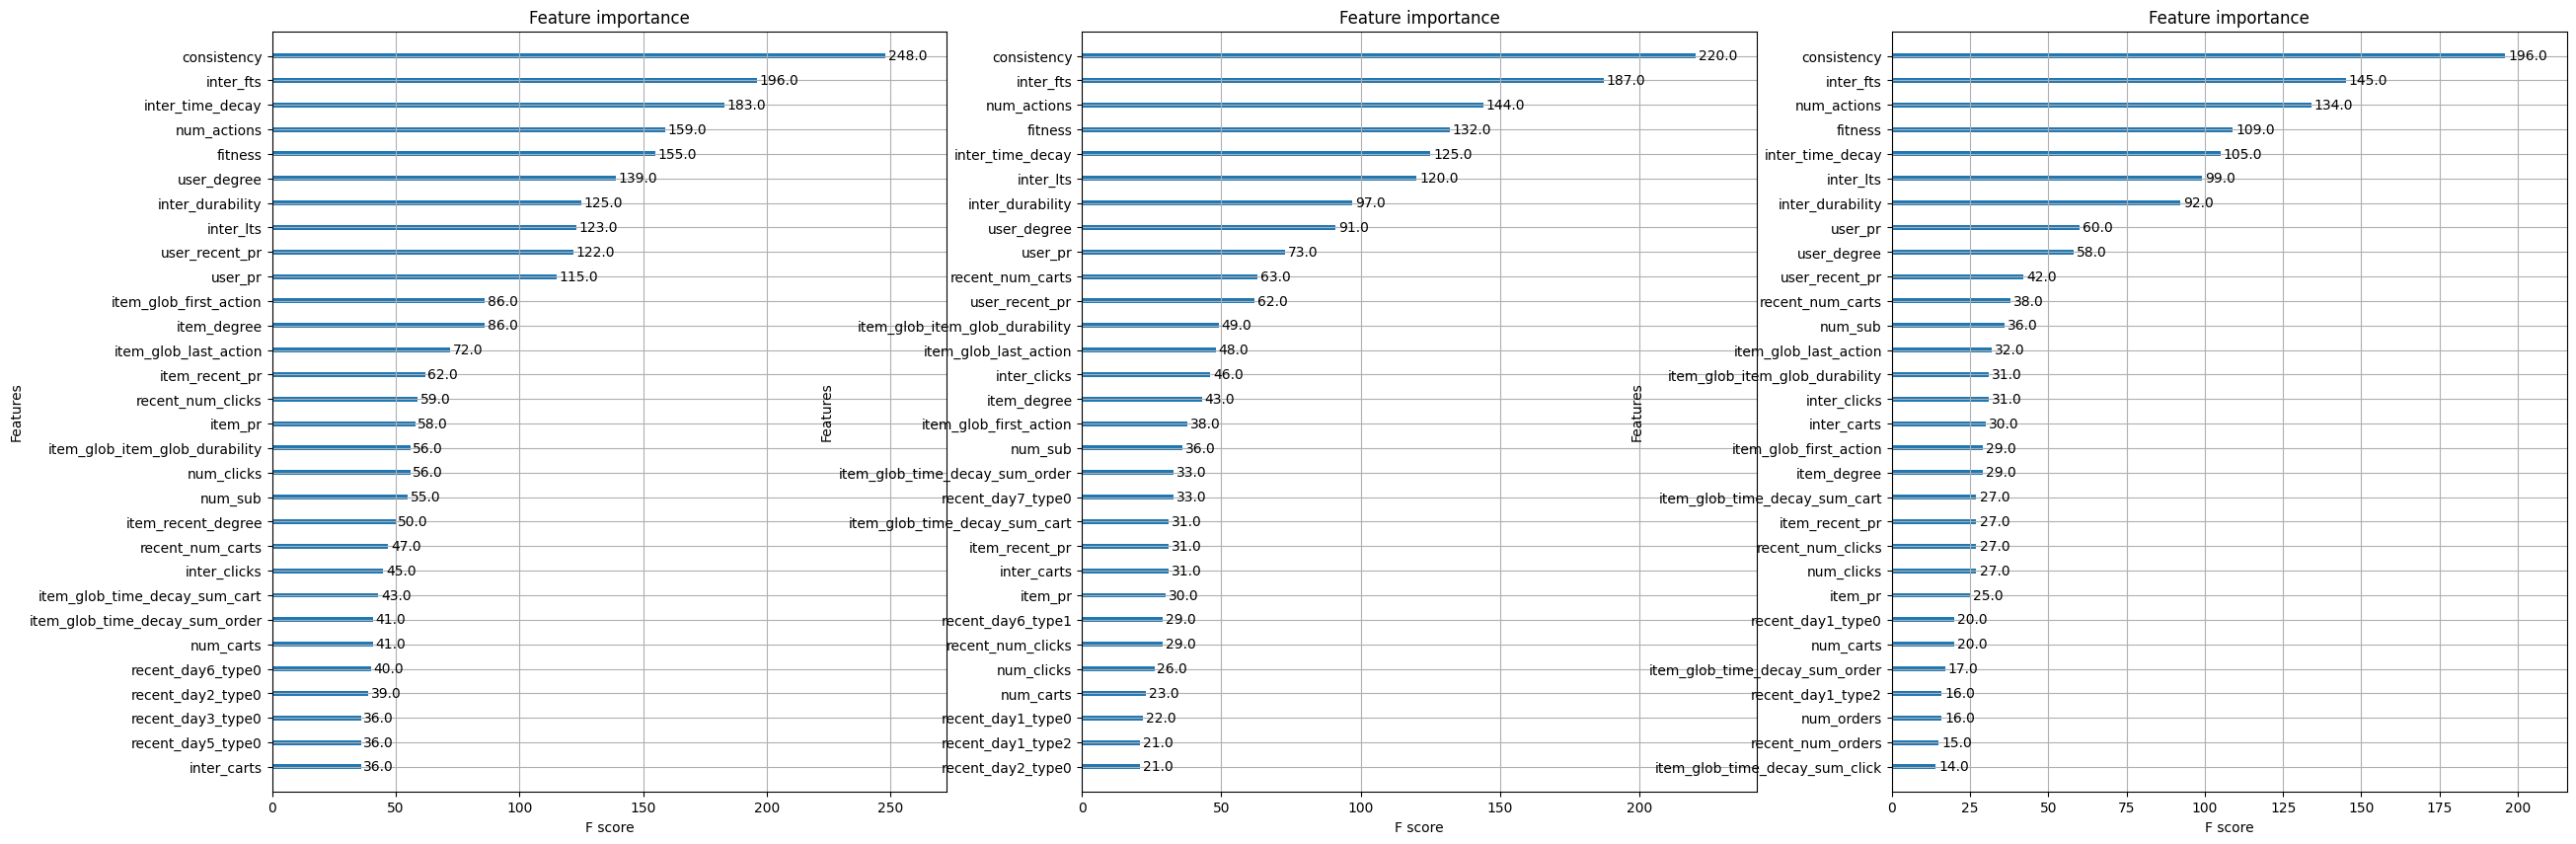

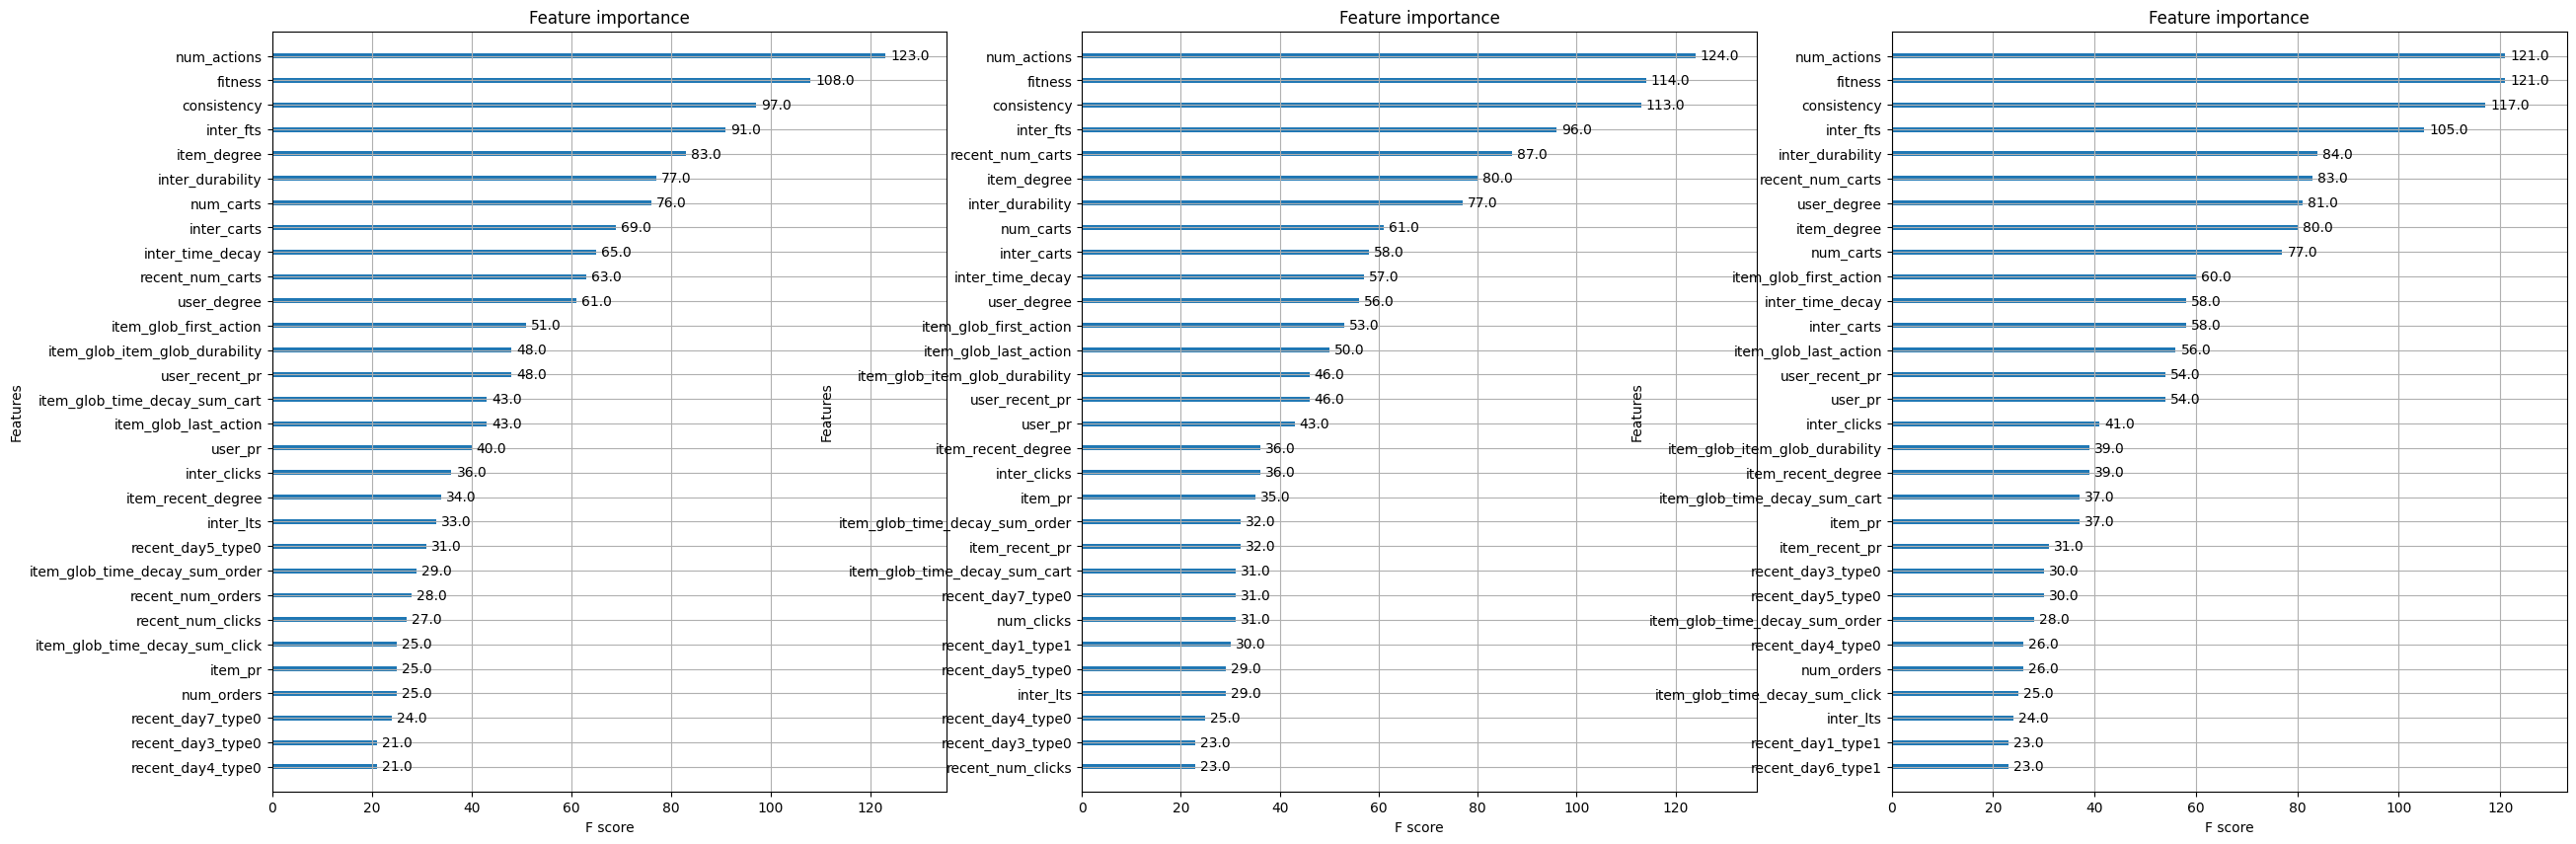

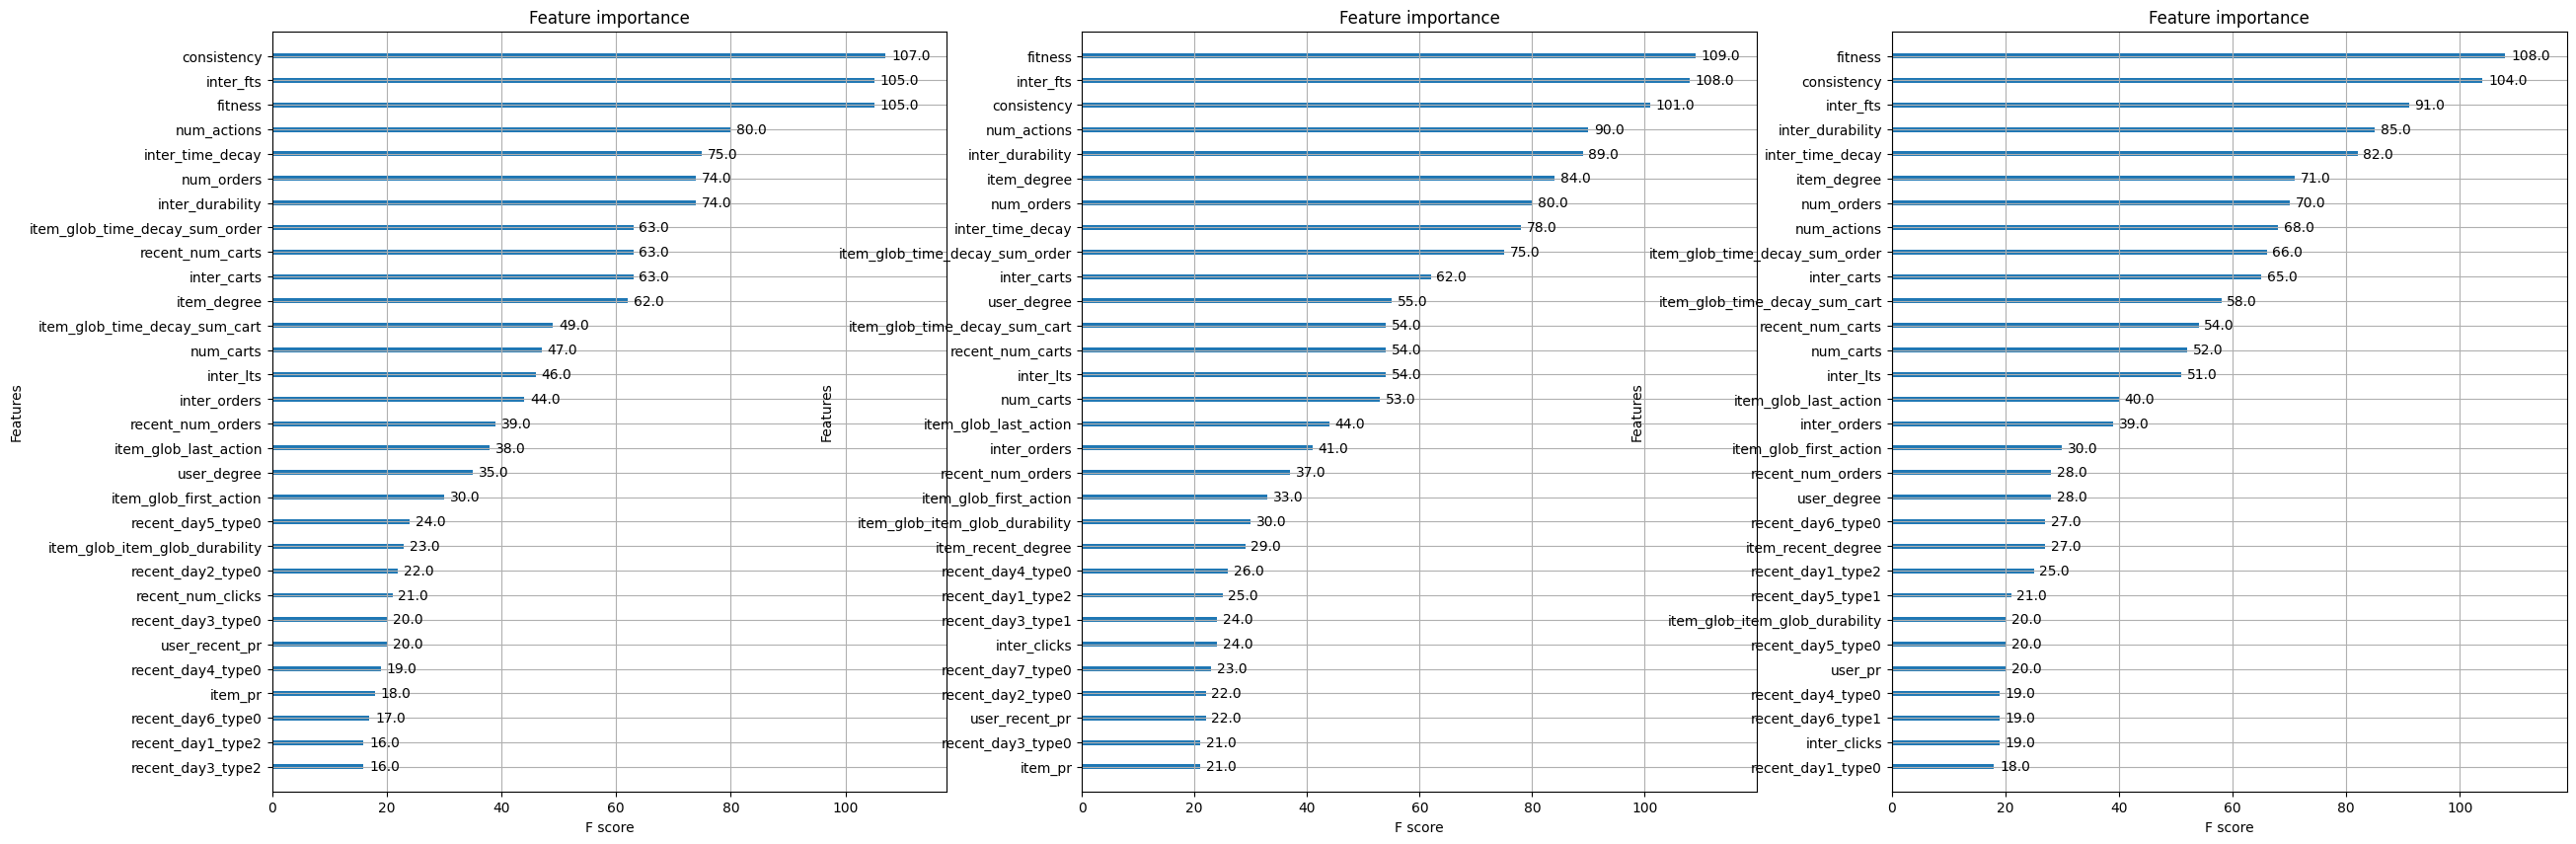

In [34]:
%%time
for id_type, t in enumerate(['clicks', 'carts', 'orders']):
  train(tar, candidates, t, num_cands, id_type)